# 🏭 Hackathon - Détection de Défauts Industriels avec IA

## 📋 Objectif
Construire un système complet de détection de défauts sur des pièces industrielles en utilisant:
- **Machine Learning / Deep Learning** pour la classification
- **CBIR** (Content-Based Image Retrieval) pour la recherche par similarité
- **VLM** (Vision Language Model) pour la description automatique

---

## 🗓️ Programme
| Jour | Thème | Livrables |
|------|-------|----------|
| 1 | Fondamentaux | Pipeline ML/DL baseline |
| 2 | Optimisation | Hyperparamètres + Interface Streamlit |
| 3 | CBIR | Système de recherche par similarité |
| 4 | VLM | Description automatique + Intégration finale |

---

## ⚠️ Règles du Hackathon
- ✅ Utiliser les ressources fournies
- ✅ Collaborer en équipe
- ✅ Documenter votre code
- ❌ Ne pas copier le code final des autres équipes

**Bonne chance! 🚀**

---
# 📦 SECTION 0: Configuration de l'Environnement
---

In [ ]:
# Installation des dépendances (décommenter si nécessaire)
!pip install torch torchvision scikit-learn xgboost lightgbm
!pip install matplotlib seaborn pillow
!pip install transformers accelerate  # Pour VLM

In [ ]:
# Imports de base
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

PyTorch version: 2.9.0+cu126
CUDA available: True
Using device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Configuration des chemins - À MODIFIER selon votre structure
DATA_DIR = Path("/content/drive/MyDrive/IA week group 6/casting_data/casting_data")
TRAIN_DIR = DATA_DIR / "train"
TEST_DIR = DATA_DIR / "test"
MODELS_DIR = Path("./models")
MODELS_DIR.mkdir(exist_ok=True)

# Classes
CLASSES = ['ok_front', 'def_front']
NUM_CLASSES = 2

# Paramètres images
IMG_SIZE = 224
BATCH_SIZE = 32

---
# 📊 SECTION 1: Exploration des Données (EDA)
---

## 💡 Objectif
Comprendre la distribution de vos données avant de construire le modèle.

## 🎯 TODO pour votre équipe:
1. Compter le nombre d'images par classe
2. Visualiser quelques exemples
3. Vérifier la taille et qualité des images

Distribution Train: {'ok_front': 2870, 'def_front': 2399}
Distribution Test: {'ok_front': 262, 'def_front': 453}


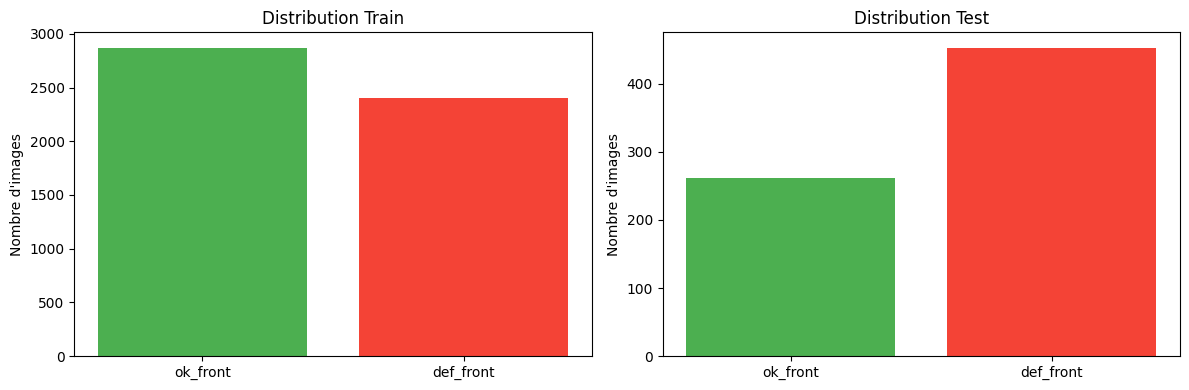

In [ ]:
# Compter les images par classe
def count_images(directory):
    """
    Compte le nombre d'images par classe dans un répertoire.

    Args:
        directory: Chemin vers le répertoire (train ou test)

    Returns:
        dict: {'ok_front': count, 'def_front': count}
    """
    counts = {}
    directory = Path(directory)

    for class_name in CLASSES:
        class_dir = directory / class_name
        if class_dir.exists():
            # Compter les fichiers image (.jpeg, .jpg, .png)
            image_files = [
                f for f in class_dir.iterdir()
                if f.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp']
            ]
            counts[class_name] = len(image_files)
        else:
            counts[class_name] = 0

    return counts

# Test
print("Distribution Train:", count_images(TRAIN_DIR))
print("Distribution Test:", count_images(TEST_DIR))

# Visualisation de la distribution
train_counts = count_images(TRAIN_DIR)
test_counts = count_images(TEST_DIR)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.bar(train_counts.keys(), train_counts.values(), color=['#4CAF50', '#F44336'])
ax1.set_title('Distribution Train')
ax1.set_ylabel('Nombre d\'images')

ax2.bar(test_counts.keys(), test_counts.values(), color=['#4CAF50', '#F44336'])
ax2.set_title('Distribution Test')
ax2.set_ylabel('Nombre d\'images')

plt.tight_layout()
plt.show()

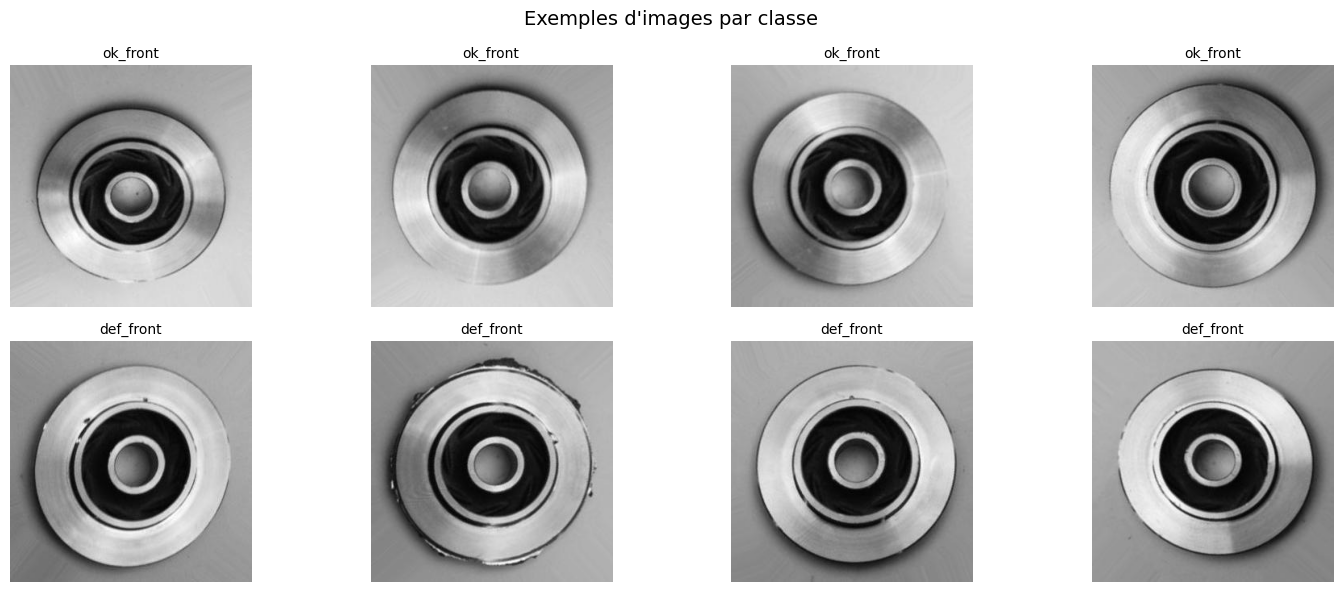

In [ ]:
# Visualiser des exemples d'images
def visualize_samples(directory, n_samples=4):
    """
    Affiche des exemples d'images pour chaque classe.
    Classes: ok_front (non défectueux) et def_front (défectueux)
    """
    fig, axes = plt.subplots(2, n_samples, figsize=(15, 6))

    for i, class_name in enumerate(CLASSES):
        class_dir = Path(directory) / class_name
        # Lister les fichiers image
        image_files = sorted([
            f for f in class_dir.iterdir()
            if f.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp']
        ])

        # Sélectionner n_samples images aléatoires
        selected = np.random.choice(len(image_files), min(n_samples, len(image_files)), replace=False)

        for j in range(n_samples):
            if j < len(selected):
                img = Image.open(image_files[selected[j]])
                axes[i, j].imshow(img, cmap='gray' if img.mode == 'L' else None)
                axes[i, j].set_title(f"{class_name}", fontsize=10)
            axes[i, j].axis('off')

    # Titres des lignes
    axes[0, 0].set_ylabel('OK (non défaut)', fontsize=12)
    axes[1, 0].set_ylabel('Défaut', fontsize=12)

    plt.suptitle('Exemples d\'images par classe', fontsize=14)
    plt.tight_layout()
    plt.show()

visualize_samples(TRAIN_DIR)

### ❓ Questions de réflexion:
1. Vos classes sont-elles équilibrées?
2. Quelles caractéristiques visuelles distinguent les défauts?
3. Y a-t-il des variations de luminosité/angle dans les images?

---
# 🖼️ SECTION 2: Prétraitement des Images
---

## 💡 Concepts clés

### Normalisation ImageNet
Les modèles pré-entraînés (VGG, ResNet) attendent des images normalisées:
- **Mean**: [0.485, 0.456, 0.406]
- **Std**: [0.229, 0.224, 0.225]

### Data Augmentation
Techniques pour augmenter artificiellement le dataset:
- Rotation, flip horizontal
- Variation de luminosité
- Crop aléatoire

In [ ]:
# Transforms pour l'entraînement (avec augmentation)
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Transforms pour test/inférence (PAS d'augmentation)
test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

print(" Transforms définis")

 Transforms définis


In [ ]:
class DefectDataset(Dataset):
    """
    Dataset pour les images de défauts.

    Structure attendue:
    data_dir/
    ├── ok_front/       # Classe 0 (non defective)
    │   └── *.jpg, *.png
    └── def_front/      # Classe 1 (defective)
        └── *.jpg, *.png
    """

    def __init__(self, data_dir, transform=None):
        self.data_dir = Path(data_dir)
        self.transform = transform
        self.samples = []  # Liste de (chemin_image, label)

        # Remplir self.samples en parcourant chaque classe
        for class_idx, class_name in enumerate(CLASSES):
            class_dir = self.data_dir / class_name
            if not class_dir.exists():
                raise FileNotFoundError(f"Le répertoire {class_dir} n'existe pas")

            # Parcourir toutes les images dans le répertoire de la classe
            for img_path in class_dir.glob("*.*"):
                if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                    self.samples.append((img_path, class_idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]

        # Charger et transformer l'image
        image = Image.open(img_path).convert('RGB')  # Convertir en RGB pour éviter les problèmes avec les images en niveaux de gris
        if self.transform:
            image = self.transform(image)

        return image, label

# Test
train_dataset = DefectDataset(TRAIN_DIR, transform=train_transform)
print(f"Nombre d'images d'entraînement: {len(train_dataset)}")

# Test avec une image
if len(train_dataset) > 0:
    sample_img, sample_label = train_dataset[0]
    print(f"Taille de l'image: {sample_img.shape}")
    print(f"Label: {sample_label} ({CLASSES[sample_label]})")


Nombre d'images d'entraînement: 5269
Taille de l'image: torch.Size([3, 224, 224])
Label: 0 (ok_front)


---
# 🧠 SECTION 3: Extraction de Caractéristiques avec CNN
---

## 💡 Concept: Transfer Learning

Utiliser un CNN pré-entraîné sur ImageNet comme **extracteur de features**:
1. Charger le modèle (VGG16, ResNet50, etc.)
2. Retirer la dernière couche (classification)
3. Passer l'image → Obtenir un vecteur de features

### Dimensions des features par modèle:
| Modèle | Dimension |
|--------|----------|
| VGG16 | 4096 |
| ResNet50 | 2048 |
| DenseNet121 | 1024 |
| MobileNetV2 | 1280 |

In [ ]:
class FeatureExtractor(nn.Module):
    """
    Extrait les features d'une image en utilisant un CNN pré-entraîné.
    """

    def __init__(self, model_name='resnet50'):
        super().__init__()

        if model_name == 'resnet50':
            base_model = models.resnet50(pretrained=True)
            # Retirer la dernière couche FC
            self.features = nn.Sequential(*list(base_model.children())[:-1])
            self.output_dim = 2048

        elif model_name == 'vgg16':
            base_model = models.vgg16(pretrained=True)
            self.features = base_model.features
            self.avgpool = base_model.avgpool
            # Utiliser seulement les features, pas le classifier
            self.output_dim = 512 * 7 * 7  # 25088

        elif model_name == 'densenet121':
            base_model = models.densenet121(pretrained=True)
            self.features = base_model.features
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
            self.output_dim = 1024

        elif model_name == 'mobilenet_v2':
            base_model = models.mobilenet_v2(pretrained=True)
            self.features = base_model.features
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
            self.output_dim = 1280

        # Geler les poids (pas de fine-tuning)
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = self.features(x)
        if hasattr(self, 'avgpool'):
            x = self.avgpool(x)
        x = x.view(x.size(0), -1)  # Flatten
        return x


In [ ]:
import time
from datetime import timedelta

def extract_all_features(data_dir, extractor, transform):
    """
    Extrait les features de toutes les images d'un répertoire.

    Returns:
        features: np.array de shape (n_samples, feature_dim)
        labels: np.array de shape (n_samples,)
        paths: liste des chemins d'images
    """
    features_list = []
    labels_list = []
    paths_list = []

    extractor.eval()

    # Timer global
    start_time = time.time()
    total_images = 0

    # Parcourir chaque classe
    for class_idx, class_name in enumerate(CLASSES):
        class_dir = Path(data_dir) / class_name
        class_start = time.time()
        class_count = 0

        print(f"\n Traitement de la classe: {class_name}")

        # Parcourir chaque image dans le répertoire de la classe
        for img_path in class_dir.glob("*.*"):
            if img_path.suffix.lower() not in ['.jpg', '.jpeg', '.png']:
                continue

            try:
                # 1. Charger l'image avec PIL
                img = Image.open(img_path).convert('RGB')

                # 2. Appliquer transform
                img_tensor = transform(img).unsqueeze(0).to(DEVICE)

                # 3. Passer dans extractor
                with torch.no_grad():
                    features = extractor(img_tensor).cpu().numpy()

                # 4. Ajouter aux listes
                features_list.append(features.squeeze())
                labels_list.append(class_idx)
                paths_list.append(str(img_path))

                class_count += 1
                total_images += 1

                # Afficher progression toutes les 100 images
                if total_images % 100 == 0:
                    elapsed = time.time() - start_time
                    speed = total_images / elapsed
                    print(f"  {total_images} images traitées ({speed:.1f} img/s)")

            except Exception as e:
                print(f"   Erreur avec l'image {img_path}: {str(e)}")
                continue

        # Stats par classe
        class_elapsed = time.time() - class_start
        print(f"  {class_name}: {class_count} images en {class_elapsed:.2f}s")

    # Stats finales
    total_time = time.time() - start_time
    avg_time = total_time / total_images if total_images > 0 else 0

    print(f"\n{'='*60}")
    print(f"EXTRACTION TERMINÉE")
    print(f"{'='*60}")
    print(f"  Temps total: {timedelta(seconds=int(total_time))}")
    print(f"Images traitées: {total_images}")
    print(f"Vitesse moyenne: {total_images/total_time:.2f} img/s")
    print(f"Temps moyen/image: {avg_time*1000:.2f} ms")
    print(f"{'='*60}\n")

    return np.array(features_list), np.array(labels_list), paths_list


# Création de l'extracteur
print("Initialisation de l'extracteur...")
extractor_start = time.time()

extractor = FeatureExtractor(model_name='resnet50')
extractor = extractor.to(DEVICE)
extractor.eval()

extractor_time = time.time() - extractor_start
print(f"Extracteur créé en {extractor_time:.2f}s\n")

# Extraction des features
print("="*60)
print("EXTRACTION DES FEATURES - TRAIN SET")
print("="*60)

X_train, y_train, paths_train = extract_all_features(TRAIN_DIR, extractor, test_transform)

print(f"Features train: {X_train.shape}")
print(f"Labels train: {y_train.shape}")
print(f"Nombre de chemins: {len(paths_train)}")


Initialisation de l'extracteur...
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 218MB/s]


Extracteur créé en 1.24s

EXTRACTION DES FEATURES - TRAIN SET

 Traitement de la classe: ok_front
  100 images traitées (2.5 img/s)
  200 images traitées (4.8 img/s)
  300 images traitées (7.0 img/s)
  400 images traitées (9.1 img/s)
  500 images traitées (11.1 img/s)
  600 images traitées (12.9 img/s)
  700 images traitées (14.7 img/s)
  800 images traitées (16.5 img/s)
  900 images traitées (18.1 img/s)
  1000 images traitées (19.7 img/s)
  1100 images traitées (21.2 img/s)
  1200 images traitées (22.7 img/s)
  1300 images traitées (24.1 img/s)
  1400 images traitées (25.4 img/s)
  1500 images traitées (26.7 img/s)
  1600 images traitées (28.0 img/s)
  1700 images traitées (29.2 img/s)
  1800 images traitées (30.3 img/s)
  1900 images traitées (31.4 img/s)
  2000 images traitées (32.5 img/s)
  2100 images traitées (33.5 img/s)
  2200 images traitées (34.4 img/s)
  2300 images traitées (35.4 img/s)
  2400 images traitées (36.3 img/s)
  2500 images traitées (37.2 img/s)
  2600 images t

In [ ]:
X_test, y_test, paths_test = extract_all_features(TEST_DIR, extractor, test_transform)



 Traitement de la classe: ok_front
  100 images traitées (26.7 img/s)
  200 images traitées (41.3 img/s)
  ok_front: 262 images en 5.56s

 Traitement de la classe: def_front
  300 images traitées (27.0 img/s)
  400 images traitées (32.8 img/s)
  500 images traitées (37.7 img/s)
  600 images traitées (41.9 img/s)
  700 images traitées (45.6 img/s)
  def_front: 453 images en 9.95s

EXTRACTION TERMINÉE
  Temps total: 0:00:15
Images traitées: 715
Vitesse moyenne: 46.11 img/s
Temps moyen/image: 21.69 ms



---
# 🧠 SECTION 3b: Entraînement CNN Baseline (Deep Learning)
---

## 💡 Objectif
Entraîner un CNN from scratch pour comparer avec l'approche hybride (features pré-entraînées + shallow classifiers).

### Architecture suggérée:
```
Input (224×224×3)
    ↓
Conv2D(32) → BatchNorm → ReLU → MaxPool
    ↓
Conv2D(64) → BatchNorm → ReLU → MaxPool
    ↓
Conv2D(128) → BatchNorm → ReLU → MaxPool
    ↓
Conv2D(256) → BatchNorm → ReLU → MaxPool
    ↓
Global Average Pooling
    ↓
FC(256) → ReLU → Dropout
    ↓
FC(2) → Softmax
```

In [ ]:
# =============================================================================
# 🧠 SECTION 3b: Entraînement CNN Baseline (Deep Learning)
# =============================================================================

class BaselineCNN(nn.Module):
    """
    CNN simple entraîné from scratch pour la classification binaire.

    Architecture:
        Input (224×224×3)
        → Conv2D(32) → BatchNorm → ReLU → MaxPool
        → Conv2D(64) → BatchNorm → ReLU → MaxPool
        → Conv2D(128) → BatchNorm → ReLU → MaxPool
        → Conv2D(256) → BatchNorm → ReLU → MaxPool
        → Global Average Pooling
        → FC(256) → ReLU → Dropout
        → FC(2) → Softmax
    """

    def __init__(self, num_classes=2):
        super().__init__()

        # Définir les couches convolutionnelles
        self.features = nn.Sequential(
            # Block 1: 3 → 32
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2: 32 → 64
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3: 64 → 128
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4: 128 → 256
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Global Average Pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x


# Test du modèle
model = BaselineCNN().to(DEVICE)
dummy = torch.randn(1, 3, 224, 224).to(DEVICE)
output = model(dummy)
print(f"Output shape: {output.shape}")  # Devrait être (1, 2)


Output shape: torch.Size([1, 2])


In [ ]:
from torchvision import datasets

# Création des datasets en utilisant tes variables existantes
train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transform)
val_dataset = datasets.ImageFolder(root=TEST_DIR, transform=test_transform)

# Création des chargeurs de données
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"DataLoaders prêts : {len(train_dataset)} images train, {len(val_dataset)} images val/test.")

DataLoaders prêts : 5269 images train, 715 images val/test.


In [ ]:
def train_cnn(model, train_loader, val_loader, epochs=20, lr=0.0005  ):
    """
    Entraîne le CNN avec early stopping.

    Args:
        model: Le CNN à entraîner
        train_loader: DataLoader d'entraînement
        val_loader: DataLoader de validation
        epochs: Nombre d'époques maximum
        lr: Learning rate

    Returns:
        model: Le modèle entraîné
        history: Dict avec les métriques par époque
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )

    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        # 1. model.train()
        model.train()
        train_loss = 0.0

        # 2. Pour chaque batch: forward → loss → backward → step
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # 3. model.eval() pour validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # 4. Calculer val_loss et val_acc
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = correct / total

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        scheduler.step(val_loss)

        # 5. Early stopping si pas d'amélioration
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_cnn_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= 2:
                print(f"Early stopping à l'époque {epoch+1}")
                break

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}")

    return model, history
cnn_model = BaselineCNN().to(DEVICE)
cnn_model, history = train_cnn(cnn_model, train_loader, val_loader, epochs=10)

Epoch 1/10 - Train Loss: 0.5825 - Val Loss: 0.6300 - Val Acc: 0.5902
Epoch 2/10 - Train Loss: 0.3590 - Val Loss: 1.0624 - Val Acc: 0.5497
Epoch 3/10 - Train Loss: 0.2374 - Val Loss: 0.2393 - Val Acc: 0.8839
Epoch 4/10 - Train Loss: 0.1869 - Val Loss: 2.7047 - Val Acc: 0.4266
Early stopping à l'époque 5


In [ ]:
def

Epoch 1/10 - Train Loss: 0.5825 - Val Loss: 0.6300 - Val Acc: 0.5902
Epoch 2/10 - Train Loss: 0.3590 - Val Loss: 1.0624 - Val Acc: 0.5497
Epoch 3/10 - Train Loss: 0.2374 - Val Loss: 0.2393 - Val Acc: 0.8839
Epoch 4/10 - Train Loss: 0.1869 - Val Loss: 2.7047 - Val Acc: 0.4266
Early stopping à l'époque 5


In [ ]:
cnn_model.load_state_dict(torch.load('best_cnn_model.pth'))

<All keys matched successfully>

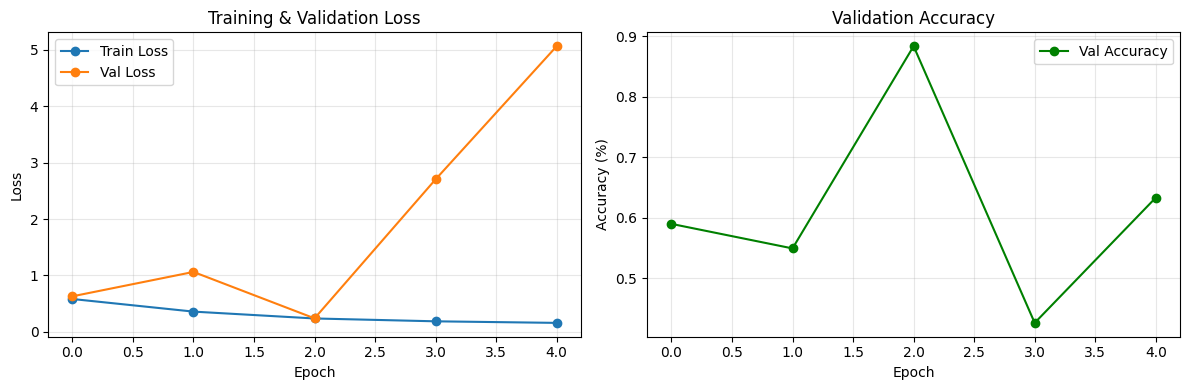

In [ ]:
# Visualiser les courbes d'apprentissage
def plot_training_history(history):
    """
    Affiche les courbes de loss et accuracy.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Loss
    ax1.plot(history['train_loss'], label='Train Loss', marker='o')
    ax1.plot(history['val_loss'], label='Val Loss', marker='o')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.set_title('Training & Validation Loss')
    ax1.grid(True, alpha=0.3)

    # Accuracy
    ax2.plot(history['val_acc'], label='Val Accuracy', color='green', marker='o')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.set_title('Validation Accuracy')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_training_history(history)


### 💡 Optimisation du CNN (si nécessaire)

Si les performances ne sont pas satisfaisantes:
1. **Data Augmentation** plus agressive
2. **Learning Rate Scheduler** (ReduceLROnPlateau)
3. **Regularization** (Dropout, Weight Decay)
4. **Architecture** (plus de couches, plus de filtres)
5. **Transfer Learning** (fine-tuning d'un modèle pré-entraîné)


ENTRAÎNEMENT DU MODÈLE FINE-TUNÉ (ResNet50)
Epoch 1/10 - Train Loss: 0.6035 - Val Loss: 0.6566 - Val Acc: 0.5427
Epoch 2/10 - Train Loss: 0.4826 - Val Loss: 0.5665 - Val Acc: 0.6266
Epoch 3/10 - Train Loss: 0.4233 - Val Loss: 0.4898 - Val Acc: 0.7161
Epoch 4/10 - Train Loss: 0.3851 - Val Loss: 0.4973 - Val Acc: 0.6993
Epoch 5/10 - Train Loss: 0.3559 - Val Loss: 0.4134 - Val Acc: 0.7804
Epoch 6/10 - Train Loss: 0.3324 - Val Loss: 0.3597 - Val Acc: 0.8294
Epoch 7/10 - Train Loss: 0.3213 - Val Loss: 0.3784 - Val Acc: 0.8014
Early stopping à l'époque 8


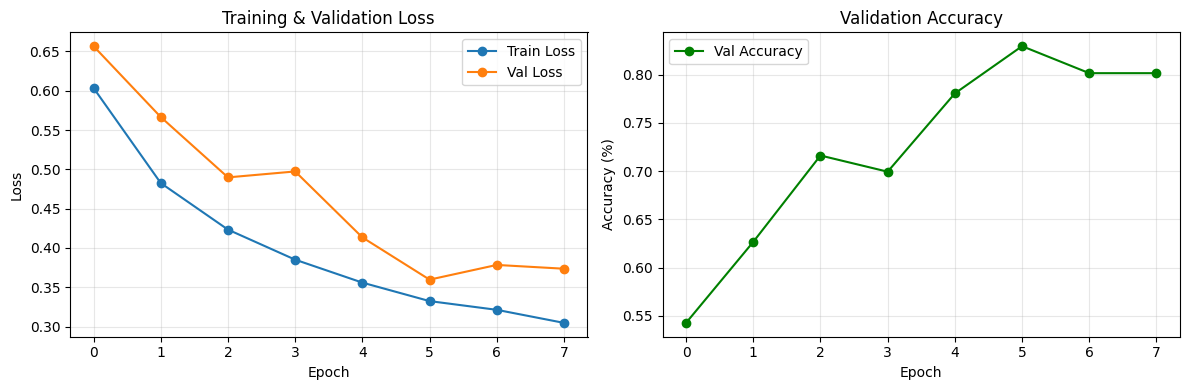

In [ ]:
def create_finetuned_model(model_name='resnet50', num_classes=2, freeze_ratio=0.8):
    """
    Crée un modèle pré-entraîné pour fine-tuning.

    Args:
        model_name: 'resnet50', 'vgg16', etc.
        num_classes: Nombre de classes (2 pour notre cas)
        freeze_ratio: Proportion des couches à geler (0.8 = 80% gelées)
    """
    if model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
        # Remplacer la dernière couche
        model.fc = nn.Linear(model.fc.in_features, num_classes)

        # Geler les premières couches
        layers = list(model.children())
        freeze_until = int(len(layers) * freeze_ratio)
        for i, layer in enumerate(layers[:freeze_until]):
            for param in layer.parameters():
                param.requires_grad = False

    elif model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
        # Remplacer la dernière couche du classifier
        model.classifier[6] = nn.Linear(4096, num_classes)

        # Geler les couches features selon freeze_ratio
        features_layers = list(model.features.children())
        freeze_until = int(len(features_layers) * freeze_ratio)
        for i, layer in enumerate(features_layers[:freeze_until]):
            for param in layer.parameters():
                param.requires_grad = False

    elif model_name == 'densenet121':
        model = models.densenet121(pretrained=True)
        # Remplacer le classifier
        model.classifier = nn.Linear(1024, num_classes)

        # Geler les couches features selon freeze_ratio
        features_layers = list(model.features.children())
        freeze_until = int(len(features_layers) * freeze_ratio)
        for i, layer in enumerate(features_layers[:freeze_until]):
            for param in layer.parameters():
                param.requires_grad = False

    return model

# Entraînement du modèle fine-tuné
print("\n" + "="*60)
print("ENTRAÎNEMENT DU MODÈLE FINE-TUNÉ (ResNet50)")
print("="*60)
model_ft = create_finetuned_model('resnet50').to(DEVICE)
model_ft, history_ft = train_cnn(model_ft, train_loader, val_loader, epochs=10, lr=0.0001)
model_ft.load_state_dict(torch.load('best_cnn_model.pth'))
plot_training_history(history_ft)

---
# 📊 SECTION 3c: Comparaison CNN vs Shallow Methods
---

## 🎯 Objectif
Comparer les performances de:
1. **CNN Baseline** (entraîné from scratch)
2. **CNN Fine-tuné** (transfer learning)
3. **Features pré-entraînées + Shallow Classifiers**

In [ ]:
# TODO: Créer un tableau de comparaison
def compare_models(models_results):
    """
    Compare les performances de plusieurs modèles.

    Args:
        models_results: Dict {'model_name': {'accuracy': ..., 'recall': ..., 'f1': ...}}

    Returns:
        DataFrame avec la comparaison
    """
    df = pd.DataFrame(models_results).T
    df = df.sort_values('f1', ascending=False)

    # Afficher avec style
    styled = df.style.background_gradient(cmap='Greens', subset=['accuracy', 'recall', 'f1'])

    return styled

# Exemple d'utilisation:
# results = {
#     'CNN Baseline': {'accuracy': 0.85, 'precision': 0.83, 'recall': 0.80, 'f1': 0.82},
#     'ResNet50 + SVM': {'accuracy': 0.90, 'precision': 0.89, 'recall': 0.88, 'f1': 0.89},
#     'ResNet50 + XGBoost': {'accuracy': 0.92, 'precision': 0.91, 'recall': 0.90, 'f1': 0.91},
#     'VGG16 + RandomForest': {'accuracy': 0.88, 'precision': 0.86, 'recall': 0.85, 'f1': 0.86},
# }
# compare_models(results)

In [ ]:
# Visualisation graphique de la comparaison
def plot_model_comparison(results):
    """
    Graphique de comparaison des modèles.
    """
    df = pd.DataFrame(results).T.reset_index()
    df = df.rename(columns={'index': 'Model'})

    fig, ax = plt.subplots(figsize=(10, 6))

    x = np.arange(len(df))
    width = 0.2

    ax.bar(x - width, df['accuracy'], width, label='Accuracy', color='#2E86AB')
    ax.bar(x, df['recall'], width, label='Recall', color='#F18F01')
    ax.bar(x + width, df['f1'], width, label='F1-Score', color='#4CAF50')

    ax.set_ylabel('Score')
    ax.set_title('Comparaison des Modèles')
    ax.set_xticks(x)
    ax.set_xticklabels(df['Model'], rotation=45, ha='right')
    ax.legend()
    ax.set_ylim(0, 1)
    ax.axhline(y=0.9, color='red', linestyle='--', alpha=0.5, label='Objectif 90%')

    plt.tight_layout()
    plt.show()

# plot_model_comparison(results)

---
# 🗳️ SECTION 3d: Ensemble - Vote Majoritaire
---

## 💡 Concept

Combiner les prédictions de plusieurs modèles:
- Si la majorité prédit "Défaut" → Prédiction finale = "Défaut"
- Confiance = nombre de votes pour la classe gagnante / total des modèles

### Avantages:
- Plus robuste qu'un seul modèle
- Réduit le risque de faux négatifs
- Capture différentes "perspectives" sur les données

In [ ]:
class EnsemblePredictor:
    """
    Prédicteur ensemble avec vote majoritaire.
    """

    def __init__(self):
        self.models = {}  # {'model_name': (model, feature_extractor, scaler)}
        self.cnn_models = {}  # CNN models qui prédisent directement

    def add_shallow_model(self, name, model, feature_extractor, scaler):
        """
        Ajoute un modèle shallow (SVM, XGBoost, etc.)
        """
        self.models[name] = {
            'model': model,
            'extractor': feature_extractor,
            'scaler': scaler
        }

    def add_cnn_model(self, name, model):
        """
        Ajoute un modèle CNN (prédit directement sur l'image)
        """
        self.cnn_models[name] = model

    def predict(self, image_tensor):
        """
        Prédit avec vote majoritaire.

        Args:
            image_tensor: Tensor de l'image (1, 3, 224, 224)

        Returns:
            dict: {
                'prediction': 0 ou 1,
                'confidence': float,
                'votes': {'defective': n, 'non_defective': m},
                'model_predictions': {'model_name': pred, ...}
            }
        """
        predictions = {}

        # TODO: Prédictions des CNN
        for name, model in self.cnn_models.items():
            model.eval()
            with torch.no_grad():
                output = model(image_tensor.to(DEVICE))
                pred = output.argmax(dim=1).item()
                predictions[name] = pred

        # TODO: Prédictions des shallow models
        for name, components in self.models.items():
            extractor = components['extractor']
            scaler = components['scaler']
            model = components['model']

            # Extraire features
            extractor.eval()
            with torch.no_grad():
                features = extractor(image_tensor.to(DEVICE))
                features = features.cpu().numpy().flatten().reshape(1, -1)

            # Normaliser
            features_scaled = scaler.transform(features)

            # Prédire
            pred = model.predict(features_scaled)[0]
            predictions[name] = pred

        # Vote majoritaire
        votes = list(predictions.values())
        defective_votes = sum(votes)
        non_defective_votes = len(votes) - defective_votes

        final_pred = 1 if defective_votes > non_defective_votes else 0
        confidence = max(defective_votes, non_defective_votes) / len(votes)

        return {
            'prediction': final_pred,
            'class_name': 'Defective' if final_pred == 1 else 'Non-Defective',
            'confidence': confidence,
            'votes': {
                'defective': defective_votes,
                'non_defective': non_defective_votes
            },
            'model_predictions': predictions
        }

# Exemple d'utilisation:
# ensemble = EnsemblePredictor()
# ensemble.add_cnn_model('CNN_Baseline', cnn_model)
# ensemble.add_shallow_model('ResNet50_SVM', svm_model, resnet_extractor, scaler)
# result = ensemble.predict(image_tensor)
# print(result)

---
# 🎯 SECTION 4: Entraînement des Classifiers
---

## 💡 Approche Hybride
Deep Features (CNN) + Shallow Classifiers (ML)

### Classifiers à tester:
1. **SVM** - Support Vector Machine
2. **Random Forest** - Ensemble d'arbres
3. **XGBoost** - Gradient Boosting

In [ ]:
# Normalisation des features (IMPORTANT!)
scaler = StandardScaler()

# TODO: Normaliser vos features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Utiliser le même scaler!

In [ ]:
  # TODO: Entraîner un SVM
  def train_svm(X_train, y_train):
      """
      Entraîne un SVM avec un kernel RBF.

      Paramètres :
      - C : pénalisation des erreurs (grand C = moins de régularisation)
      - kernel : type de noyau (RBF est le plus courant)
      - gamma : influence d'un point d'entraînement (auto ou scale recommandé)
      """

      # Création du modèle SVM
      model = SVC(
          C=1.0,              # Paramètre de régularisation
          kernel="rbf",       # Kernel gaussien
          gamma="scale",      # Valeur recommandée par sklearn
          random_state=42
      )

      # Entraînement du modèle
      model.fit(X_train, y_train)

      return model

  # TODO: Entraîner un Random Forest
  def train_random_forest(X_train, y_train):
      """
      Entraîne un modèle Random Forest.

      Paramètres :
      - n_estimators : nombre d'arbres
      - max_depth : profondeur maximale des arbres
      """

      # Création du modèle Random Forest
      model = RandomForestClassifier(
          n_estimators=100,   # Nombre d'arbres
          max_depth=None,     # Arbres non limités en profondeur
          random_state=42,
          n_jobs=-1           # Utilise tous les cœurs CPU
      )

      # Entraînement du modèle
      model.fit(X_train, y_train)

      return model

In [ ]:
# Entraîner le SVM
svm_model = train_svm(X_train_scaled, y_train)

# Entraîner le Random Forest
forest_model = train_random_forest(X_train, y_train)

from joblib import dump

# Sauvegarder les modèles
dump(svm_model, 'svm_model.joblib')
dump(forest_model, 'random_forest_model.joblib')

print("Modèles sauvegardés avec succès !")

Modèles sauvegardés avec succès !


---
# 📏 SECTION 5: Évaluation du Modèle
---

## 💡 Métriques importantes

Dans le contexte industriel:
- **Recall** est CRITIQUE (ne pas manquer de défauts)
- **F1-Score** pour la balance globale

svm
RÉSULTATS D'ÉVALUATION
Accuracy:  0.9986
Precision: 1.0000
Recall:    0.9978  ⬅️ IMPORTANT!
F1-Score:  0.9989


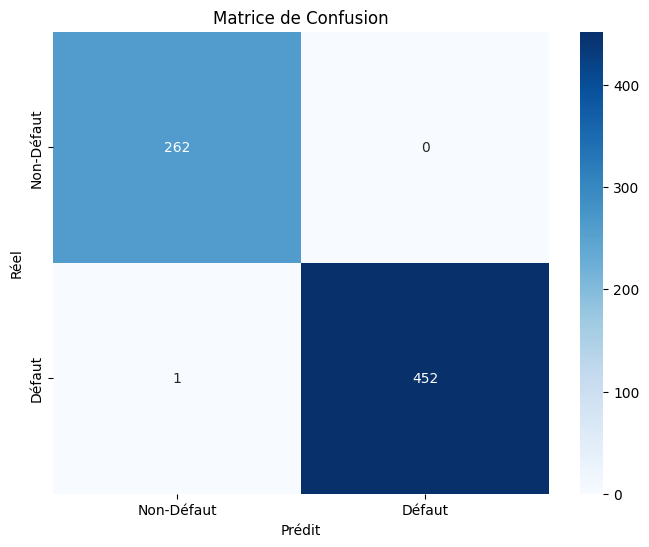

forest
RÉSULTATS D'ÉVALUATION
Accuracy:  0.6084
Precision: 0.7016
Recall:    0.6645  ⬅️ IMPORTANT!
F1-Score:  0.6825


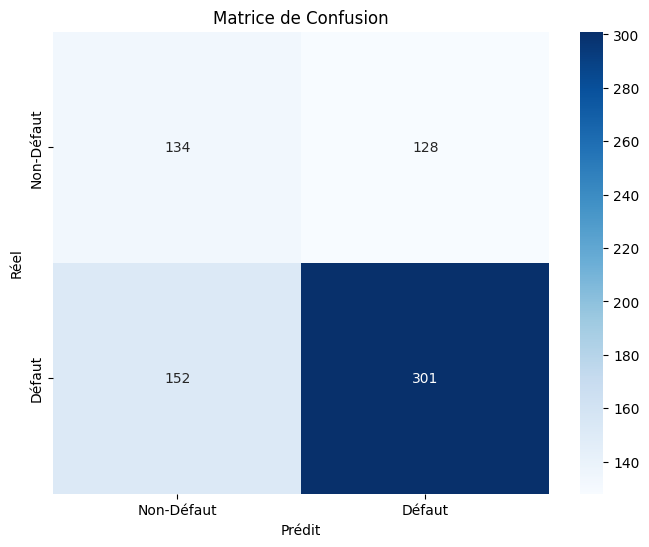

In [ ]:
def evaluate_model(model, X_test, y_test):
    """
    Évalue un modèle et affiche les métriques.
    """
    # Prédictions
    y_pred = model.predict(X_test)

    # Métriques
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print("=" * 50)
    print("RÉSULTATS D'ÉVALUATION")
    print("=" * 50)
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}  ⬅️ IMPORTANT!")
    print(f"F1-Score:  {f1:.4f}")
    print("=" * 50)

    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Défaut', 'Défaut'],
                yticklabels=['Non-Défaut', 'Défaut'])
    plt.xlabel('Prédit')
    plt.ylabel('Réel')
    plt.title('Matrice de Confusion')
    plt.show()

    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

# Usage:
print("svm")
results = evaluate_model(svm_model, X_test_scaled, y_test)
print("forest")
results = evaluate_model(forest_model, X_test_scaled, y_test)
